custom MAPE ?


# Setup

In [ ]:
%pip install xgboost

In [11]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os

## Defining functions

In [12]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [13]:
def customized_MAPE(true_values, predicted_values):
    true_values, predicted_values = np.array(true_values), np.array(predicted_values)
    Mape = np.mean(np.abs((true_values - predicted_values + 5) / (true_values + 5)))
    return Mape

In [14]:
def load_data(train_size, test_size, force_update):
    path = 'datasets/'
    if os.path.exists(path) and (not force_update):
        pass
    else:
        urls = ['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-03.parquet',
                'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-04.parquet']
        
        for index in range(len(urls)):
            response = requests.get(urls[index])
            name = path + 'm' + str(index + 1) + '.parquet'

            with open(name, 'wb') as f:
                f.write(response.content)


    train_data = []
    test_data = []
    #train part
    for i in range(train_size):
        name = path + 'm' + str(i + 1) + '.parquet'
        data = pd.read_parquet(name)
        train_data.append(data)
    #test part
    for j in range(test_size):
        name = path + 'm' + str(j + train_size + 1) + '.parquet'
        data = pd.read_parquet(name)
        test_data.append(data)
    return train_data, test_data

In [15]:
def date_format_modifier(datas):  # Year/Month/Day
    modified_datas = []
    for data in datas:
        data['month'] = pd.DataFrame([int(date.strftime("%m")) for date in data['tpep_pickup_datetime']])
        data['tpep_pickup_datetime'] = pd.DataFrame([int(date.strftime("%d")) for date in data['tpep_pickup_datetime']])
        data = data.dropna()
        modified_datas.append(data)

    return modified_datas

In [16]:
def location_format_modifier(data):  # run after merging datasets and modifing date

    data['prev_demand'] = data.groupby(['PULocationID', 'month'])['Demand'].shift(1)

    # replace "loc_id" values with previous day's "Demand" values
    data['PULocationID'] = data.apply(lambda x: x['prev_demand'] if pd.notna(x['prev_demand']) else None, axis=1)

    # drop the temporary "prev_demand" column
    data.drop(columns=['prev_demand'], inplace=True)
    data = data.dropna()

    return data

In [17]:
def grouping_by(data, group_list):
    data_grouped = data.groupby(group_list, as_index = False)['extra'].count()
    data_grouped = data_grouped.rename(columns={'extra' : 'Demand'})

    return data_grouped

In [18]:
def clearing_data_noise(datas, months):
    clean_datas = []
    for index in range(len(datas)):
        month = months[index]
        data = datas[index]

        clean_data = data[[int(date.strftime("%m")) == month for date in data['tpep_pickup_datetime']]]
        clean_data = clean_data.dropna()
        clean_datas.append(clean_data)
    return clean_datas

In [19]:
def lower_upper_bound_predict(model, model_numbers, sample_size, train_data, test_data):

    feature_num = len(group_list)
    num_samples = train_data.shape[0]
    indices = np.arange(num_samples)  # Create an array of indices

    bagging_test_predictions = []
    bagging_train_predictions = []
    for i in range(model_numbers):

      resampled_indices  = np.random.choice(indices, size = int(sample_size * num_samples), replace = True) #cant resample from n-d array so we are sampling indices
      resampled_data = train_data[resampled_indices]

      model.fit(resampled_data[:, :feature_num], resampled_data[:, feature_num:].reshape(-1,))

      test_predictions = model.predict(test_data[:, :feature_num])
      train_predictions = model.predict(train_data[:, :feature_num])

      bagging_test_predictions.append(test_predictions)
      bagging_train_predictions.append(train_predictions)

    bagging_test_predictions = np.array(bagging_test_predictions)
    bagging_train_predictions = np.array(bagging_train_predictions)

    test_lower_bound = np.percentile(bagging_test_predictions, 5, axis=0)
    test_upper_bound = np.percentile(bagging_test_predictions, 95, axis=0)

    train_lower_bound = np.percentile(bagging_train_predictions, 5, axis=0)
    train_upper_bound = np.percentile(bagging_train_predictions, 95, axis=0)

    return (train_lower_bound, train_upper_bound), (test_lower_bound, test_upper_bound)

In [20]:
def bound_visualizer(train_data, test_data, train_bounds, test_bounds, end_day):
    plot_length = len(train_data['Demand'][1: end_day])
    plt.title('Train')
    plt.plot(train_data['Demand'][1:end_day])
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), train_bounds[1][:plot_length].reshape(-1,))
    plt.show()

    plot_length = len(test_data['Demand'][1:end_day])
    plt.title('Test')
    plt.plot(test_data['Demand'][1:end_day])
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[0][:plot_length].reshape(-1,))
    plt.plot(np.linspace(1, end_day, plot_length), test_bounds[1][:plot_length].reshape(-1,))
    plt.show()

In [73]:
def grid_search(model, test_parameters, train_data, cv = None):
    gs = GridSearchCV(estimator = model, param_grid = test_parameters, scoring = 'neg_root_mean_squared_error', cv = cv, n_jobs = -1)
    gs.fit(train_data[group_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [22]:
def point_predict(model, train_data, test_data):

    feature_num = len(group_list)
    model.fit(train_data[group_list], train_data['Demand'])


    yhat_train = model.predict(train_data[group_list])
    yhat_test = model.predict(test_data[group_list])

    return yhat_train, yhat_test

In [23]:
def sum_of_demands_visualizer(data, title):
    grouped_data = data.groupby('tpep_pickup_datetime')['Demand'].sum()
    plt.title(title)
    plt.plot(grouped_data)
    plt.show()

In [24]:
def point_predict_visualizer(train_data, test_data, yhat_train, yhat_test):

    predicted_train_df = train_data.copy(deep = True)
    predicted_test_df = test_data.copy(deep = True)
    predicted_train_df['Predicted'] = yhat_train
    predicted_test_df['Predicted'] = yhat_test


    train_data = train_data.groupby('tpep_pickup_datetime')['Demand'].sum()
    test_data = test_data.groupby('tpep_pickup_datetime')['Demand'].sum()

    predicted_train_df = predicted_train_df.groupby('tpep_pickup_datetime')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('tpep_pickup_datetime')['Predicted'].sum()



    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

In [25]:
def concating_data(datas):
    data_combined = pd.concat(datas, axis=0)
    return data_combined

In [26]:
def evaluation(model_name, yhat_train, yhat_test):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_loc_modified['Demand'], yhat_train)
    evaluate(mean_squared_error, 'MSE', train_loc_modified['Demand'], yhat_train)
    evaluate(customized_MAPE, 'MAPE', train_loc_modified['Demand'], yhat_train)

    print(f'{model_name} test scores:')


    evaluate(mean_absolute_error, 'MAE', test_loc_modified['Demand'], yhat_test)
    evaluate(mean_squared_error, 'MSE', test_loc_modified['Demand'], yhat_test)
    evaluate(customized_MAPE, 'MAPE', test_loc_modified['Demand'], yhat_test)


In [27]:
def sort_metrics_values(metrics_values):
    metrics_train_values  = metrics_values['train']
    metrics_test_values = metrics_values['test']

    sorted_train_metrics = sorted(metrics_train_values, key=lambda x: x[1]['RMSE'], reverse = True)
    sorted_test_metrics = sorted(metrics_test_values, key=lambda x: x[1]['RMSE'], reverse = True)

    sorted_metrics_values = {'train': sorted_train_metrics, 'test': sorted_test_metrics}
    return sorted_metrics_values

In [28]:
def evaluate_each_location(fitted_model, train_data, test_data):
    metrics_values = {'train' : [], 'test': []}
    feature_num = len(group_list)
    for loc_id in range(loc_id_num):
        sample_train_data = train_data[train_data['PULocationID'] == loc_id].to_numpy()
        sample_test_data = test_data[test_data['PULocationID'] == loc_id].to_numpy()
        if len(sample_train_data) != 0:
            yhat_train_sample = fitted_model.predict(sample_train_data[:, :feature_num])
            metrics_values['train'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_train_data[:, feature_num:], yhat_train_sample)),
                                                      'MAE' : mean_absolute_error(sample_train_data[:, feature_num:], yhat_train_sample)}])
        if len(sample_test_data) != 0:
            yhat_test_sample = fitted_model.predict(sample_test_data[:, :feature_num])
            metrics_values['test'].append([loc_id, {'RMSE' : np.sqrt(mean_squared_error(sample_test_data[:, feature_num:], yhat_test_sample)),
                                                      'MAE' : mean_absolute_error(sample_test_data[:, feature_num:], yhat_test_sample)}])
    return sort_metrics_values(metrics_values)

In [29]:
def get_locations_mean_demand(locations_id, data):
    sum_demands = []
    for location_id in locations_id:
        sum_demands.append({location_id : data[data['PULocationID'] == location_id]['Demand'].mean()})
    return sum_demands

# Main

## initialization and loading dataset

In [30]:
group_list = ['tpep_pickup_datetime', 'month', 'PULocationID']
loc_id_num = 266
train_size = 3
test_size = 1

In [31]:
train_data, test_data = load_data(train_size, test_size, force_update = False)

## Preprocessing

In [32]:
train_data = clearing_data_noise(train_data, [1,2,3])
test_data = clearing_data_noise(test_data, [4])

In [33]:
train_date_modified = date_format_modifier(train_data)
test_date_modified = date_format_modifier(test_data)

In [34]:
train_data = concating_data(train_date_modified)
test_data = concating_data(test_date_modified)

In [35]:
train_grouped = grouping_by(train_data, group_list)
test_grouped = grouping_by(test_data, group_list)

In [36]:
train_loc_modified = location_format_modifier(train_grouped)
test_loc_modified = location_format_modifier(test_grouped)

## **Linear Regression**

#### Point based prediction

##### Grid search to find best hyper parameters

In [74]:
model = Ridge()
best_params, best_score = grid_search(model, {'alpha':[1, 10, 100, 1000, 1000]}, train_loc_modified, cv = 5)
print(best_params, best_score)

{'alpha': 1000} -236.87475773995416


In [75]:
model = Ridge(**best_params)
yhat_train, yhat_test = point_predict(model, train_loc_modified, test_loc_modified)

##### Visualization

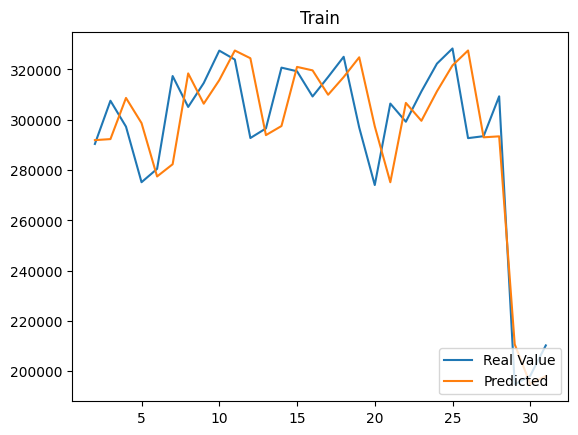

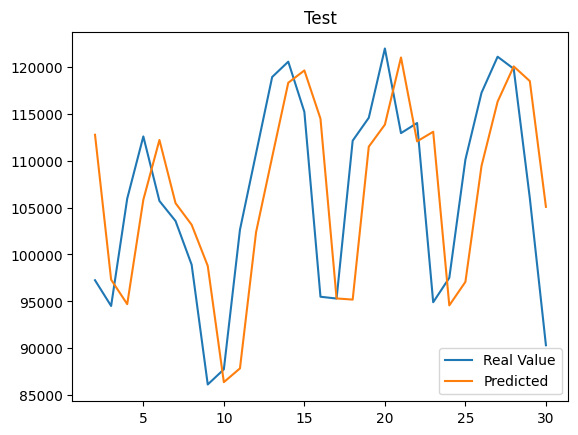

In [76]:
point_predict_visualizer(train_loc_modified, test_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [77]:
evaluation('Ridge Regression', yhat_train, yhat_test)  # for whole data

Ridge Regression train scores:
MAE : 84.2811232637709
MSE : 56133.61965818357
MAPE : 0.6435084545435992
Ridge Regression test scores:
MAE : 81.70996820957792
MSE : 51543.224469953784
MAPE : 0.449432021728799


In [ ]:
sorted_metrics_values = evaluate_each_location(model, train_loc_modified, test_loc_modified)  # for each location

In [42]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 148.4673513448736, 'MAE': 101.84952952694194}],
 [241, {'RMSE': 129.75351716064333, 'MAE': 127.18099293313104}],
 [226, {'RMSE': 120.73566129849435, 'MAE': 91.15048308405123}],
 [223, {'RMSE': 112.64237956416473, 'MAE': 84.76258129491644}],
 [206, {'RMSE': 112.33246631785725, 'MAE': 94.95192847135534}],
 [191, {'RMSE': 108.66019018248639, 'MAE': 65.75943375091822}],
 [225, {'RMSE': 108.51061369431368, 'MAE': 82.82246830029841}],
 [229, {'RMSE': 108.49943909106163, 'MAE': 80.47220204181279}],
 [207, {'RMSE': 108.35074853635528, 'MAE': 88.88150900427482}],
 [195, {'RMSE': 106.82051638680271, 'MAE': 82.33216557532737}]]

In [43]:
train_loc_modified['Demand'].mean()

469.0255772082186

In [44]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, train_loc_modified)

[{234: 318.3333333333333},
 {241: 229.0},
 {226: 163.0},
 {223: 160.66666666666666},
 {206: 166.33333333333334},
 {191: 245.66666666666666},
 {225: 147.75},
 {229: 194.0},
 {207: 277.5},
 {195: 152.0}]

In [45]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, test_loc_modified)

[{244: 38.0},
 {222: 184.0},
 {151: 40.0},
 {177: 110.5},
 {165: 78.5},
 {149: 58.0},
 {210: 119.0},
 {254: 167.0},
 {111: 170.75},
 {251: 168.0}]

## **Gradient Boosting Regressor**

#### Point based prediction

##### Grid search to find best hyper parameters

In [61]:
dtrain_reg = xgb.DMatrix(train_loc_modified[group_list].values, train_loc_modified['Demand'].values, enable_categorical=True)
dtest_reg = xgb.DMatrix(test_loc_modified[group_list].values, test_loc_modified['Demand'].values, enable_categorical=True)

In [80]:
param_test = {'max_depth':range(2,10,2), 'min_child_weight':range(1,6,2)}

params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'n_estimators':140, 'learning_rate':0.1, 'max_depth':5,
         'min_child_weight':1, 'gamma':0, 'subsample':0.8, 'colsample_bytree':0.8, 'seed':27}

best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_loc_modified, cv = 5)
print(best_params, best_score)

{'max_depth': 2, 'min_child_weight': 5} -238.60198873503435


In [81]:
params.update(best_params)
param_test = {'gamma':[i/10.0 for i in range(0,5)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_loc_modified, cv = 5)
print(best_params, best_score)

{'gamma': 0.0} -238.60198873503435


In [85]:
params.update(best_params)
param_test = {'subsample':[i/10.0 for i in range(6,10)], 'colsample_bytree':[i/10.0 for i in range(6,10)]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_loc_modified, cv = 5)
print(best_params, best_score)

{'colsample_bytree': 0.6, 'subsample': 0.9} -237.0204546297031


In [87]:
params.update(best_params)
param_test = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_loc_modified, cv = 5)
print(best_params, best_score)

{'reg_alpha': 1} -237.02005974356038


In [90]:
params.update(best_params)
param_test = {'n_estimators':list(range(1000, 5001, 500)), 'learning_rate':[0.01]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_loc_modified, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.01, 'n_estimators': 1500} -236.59626847393665


In [95]:
params.update(best_params)
param_test = {'n_estimators':list(range(15000, 20001, 500)), 'learning_rate':[0.001]}
best_params, best_score = grid_search(model = xgb.XGBRegressor(**params), test_parameters = param_test, train_data = train_loc_modified, cv = 5)
print(best_params, best_score)

{'learning_rate': 0.001, 'n_estimators': 15000} -236.53642284774014


In [96]:
params.update(best_params)
model = xgb.XGBRegressor(**params)
yhat_train, yhat_test = point_predict(model, train_loc_modified, test_loc_modified)

##### Visualization

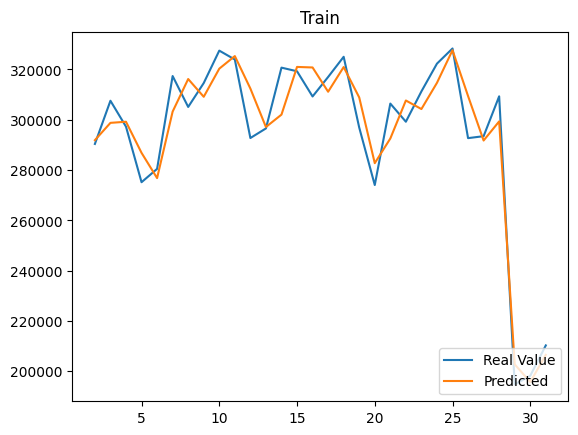

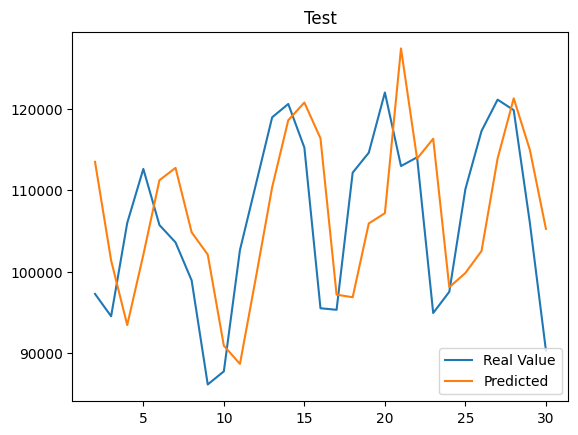

In [97]:
point_predict_visualizer(train_loc_modified, test_loc_modified, yhat_train, yhat_test)

##### Evaluation

In [98]:
evaluation('Random Forest Regressor', yhat_train, yhat_test)  # for whole data

Random Forest Regressor train scores:
MAE : 81.73003498434265
MSE : 52341.70412826802
MAPE : 0.8554591128553908
Random Forest Regressor test scores:
MAE : 85.15807912753539
MSE : 52361.989806257465
MAPE : 0.8912612321187781


In [99]:
sorted_metrics_values = evaluate_each_location(model, train_loc_modified, test_loc_modified)  # for each location

In [100]:
sorted_metrics_values['train'][:10]

[[234, {'RMSE': 162.23395336720736, 'MAE': 110.663330078125}],
 [241, {'RMSE': 136.36230768866687, 'MAE': 126.18276977539062}],
 [191, {'RMSE': 118.01525622225732, 'MAE': 71.25387064615886}],
 [218, {'RMSE': 114.2891512314893, 'MAE': 70.64225514729817}],
 [207, {'RMSE': 111.18328305151104, 'MAE': 86.17908477783203}],
 [206, {'RMSE': 107.17616430839385, 'MAE': 89.61863708496094}],
 [229, {'RMSE': 102.19579097010549, 'MAE': 78.49757766723633}],
 [195, {'RMSE': 101.94387872282147, 'MAE': 78.28988647460938}],
 [223, {'RMSE': 98.10034971722344, 'MAE': 74.2350362141927}],
 [226, {'RMSE': 93.24281933478036, 'MAE': 76.8870340983073}]]

In [101]:
train_loc_modified['Demand'].mean()

469.0255772082186

In [102]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['train'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, train_loc_modified)

[{234: 318.3333333333333},
 {241: 229.0},
 {191: 245.66666666666666},
 {218: 271.8333333333333},
 {207: 277.5},
 {206: 166.33333333333334},
 {229: 194.0},
 {195: 152.0},
 {223: 160.66666666666666},
 {226: 163.0}]

In [103]:
bad_predicted_locations_id = [value[0] for value in sorted_metrics_values['test'][:10]]
get_locations_mean_demand(bad_predicted_locations_id, test_loc_modified)

[{244: 38.0},
 {151: 40.0},
 {177: 110.5},
 {222: 184.0},
 {251: 168.0},
 {254: 167.0},
 {165: 78.5},
 {111: 170.75},
 {193: 115.0},
 {117: 116.33333333333333}]